### imports
Only astropy and astroquery required for fetching files. Also import matplotlib and astropy.fits for looking at fetched data.

In [1]:
# utilities
import os, glob

# astropy
from astroquery import sha
from astropy import coordinates as coord
from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS

# others
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/patrickkavanagh/anaconda/envs/astroconda/lib/python2.7/site-packages/astroquery/sha/__init__.py:14: UserWarning: Experimental: SHA has not yet been refactored to have its API match the rest of astroquery.
  warnings.warn("Experimental: SHA has not yet been refactored to have its "


### define test SNR coordinates
This is just row 1 of the catalogue.

In [2]:
test_src_coord = [72.091666700, -66.997777800]

### define the query instance
Instantiate the Spitzer Heritage Archive query using astroquery.sha.query

In [3]:
my_query = sha.query(coord=coord.SkyCoord(ra=test_src_coord[0], dec=test_src_coord[1],
                                          unit=(u.degree, u.degree)), size=0.001)


### print the columns of the results to get an idea of whats there
Can either use print or pprint of the astropy.table class. Just use print() here. Note that information on the contents of the results can be found here:

http://sha.ipac.caltech.edu/applications/Spitzer/SHA/help/doc/api.html


In [4]:
print(my_query.columns)

<TableColumns names=('reqkey','modedisplayname','wavelength','cra','cdec','filetype','externalname','ptcomment','ra','dec','epoch','equinox','begintime','endtime','minwavelength','maxwavelength','pbcdid','filesize','campid','ra1','dec1','ra2','dec2','ra3','dec3','ra4','dec4','naxis1','naxis2','cdelt1','cdelt2','crota2','crpix1','crpix2','crval1','crval2','ctype1','ctype2','heritagefilename','hasAccess','accessUrl','accessWithAnc1Url')>


### reduce clutter by printing only some columns and data
Print only the mode, wavelength, file type, filesize, ptcomment so we know exactly what's there.

In [5]:
my_query['modedisplayname', 'wavelength', 'filetype', 'filesize', 'ptcomment'].pprint(max_lines=100, max_width=-1) 

modedisplayname   wavelength  filetype  filesize                        ptcomment                        
---------------- ----------- --------- --------- --------------------------------------------------------
 IRAC Map         IRAC 3.6um  Image     10837440  Mosaic image (long frametime if data taken in HDR mode)
 IRAC Map         IRAC 8.0um  Image    234319680  Mosaic image (long frametime if data taken in HDR mode)
 MIPS Scan        MIPS 24um   Image     21617280  Mosaic image                                           
 IRAC Map         IRAC 3.6um  Image    292417920  Mosaic image (long frametime if data taken in HDR mode)
 IRAC Map         IRAC 5.8um  Image    292417920  Mosaic image (long frametime if data taken in HDR mode)
 IRAC Map         IRAC 8.0um  Image    292417920  Mosaic image (long frametime if data taken in HDR mode)
 MIPS Scan        MIPS 70um   Image     10296000  Mosaic image                                           
 IRAC Map         IRAC 4.5um  Image    2343196

### select only one filter for testing
We can create a mask to filter the results table for only 3.6 um IRAC images.

In [6]:
irac_36_mask = (my_query['wavelength'] == ' IRAC 3.6um')
irac_36_tbl = my_query[irac_36_mask]
irac_36_tbl['modedisplayname', 'wavelength', 'filetype', 'filesize', 'ptcomment'].pprint(max_lines=100, max_width=-1) 

modedisplayname   wavelength  filetype  filesize                        ptcomment                        
---------------- ----------- --------- --------- --------------------------------------------------------
 IRAC Map         IRAC 3.6um  Image     10837440  Mosaic image (long frametime if data taken in HDR mode)
 IRAC Map         IRAC 3.6um  Image    292417920  Mosaic image (long frametime if data taken in HDR mode)
 IRAC Map         IRAC 3.6um  Image    234290880  Mosaic image (long frametime if data taken in HDR mode)
 IRAC Map         IRAC 3.6um  Image    234319680  Mosaic image (long frametime if data taken in HDR mode)


### download the 3.6 um images
Saved to the test_files_3.6um folder

In [7]:
for u in irac_36_tbl['accessUrl']:
    print("Getting: {}".format(u))
    url = u.strip()
    sha.save_file(url, out_dir='test_files_3.6um/')

Getting:  http://sha.ipac.caltech.edu/applications/Spitzer/SHA/servlet/ProductDownload?DATASET=level2&ID=8311994    
Getting:  http://sha.ipac.caltech.edu/applications/Spitzer/SHA/servlet/ProductDownload?DATASET=level2&ID=8588810    
Getting:  http://sha.ipac.caltech.edu/applications/Spitzer/SHA/servlet/ProductDownload?DATASET=level2&ID=8698015    
Getting:  http://sha.ipac.caltech.edu/applications/Spitzer/SHA/servlet/ProductDownload?DATASET=level2&ID=8692090    


### plot the images
Use astropy.io.fits to read the images and plot.

/Users/patrickkavanagh/anaconda/envs/astroconda/lib/python2.7/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


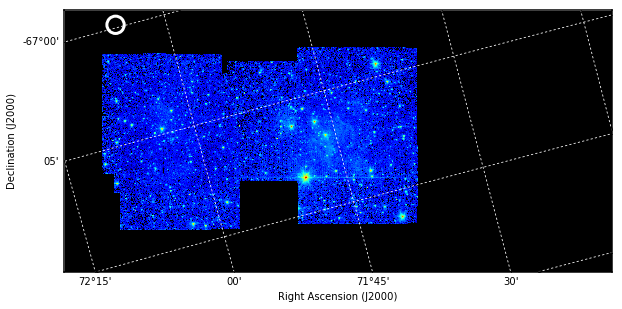

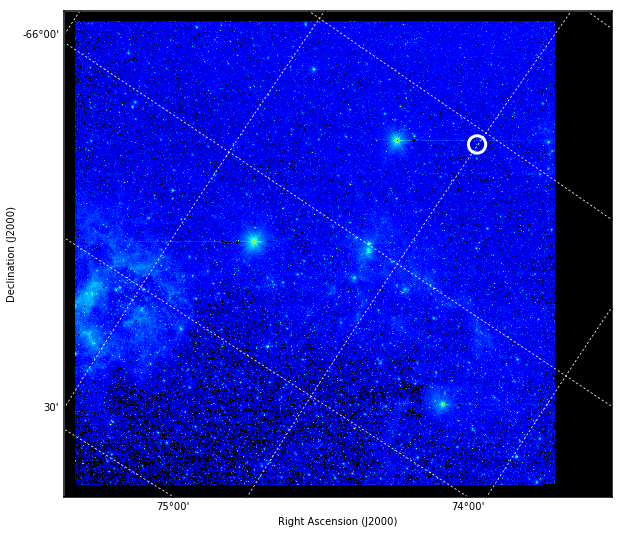

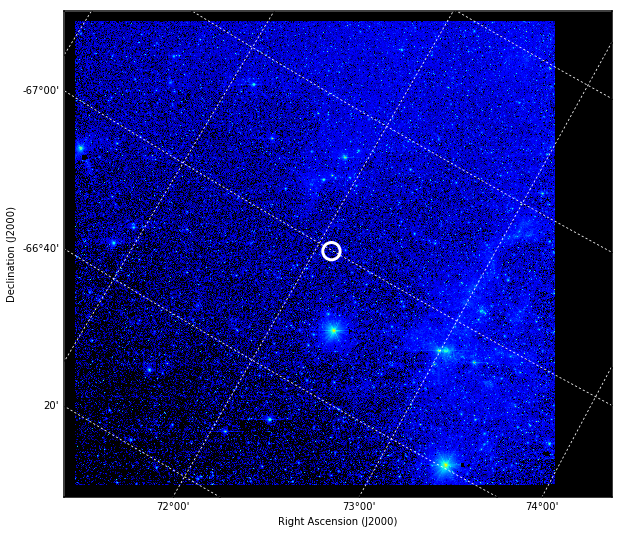

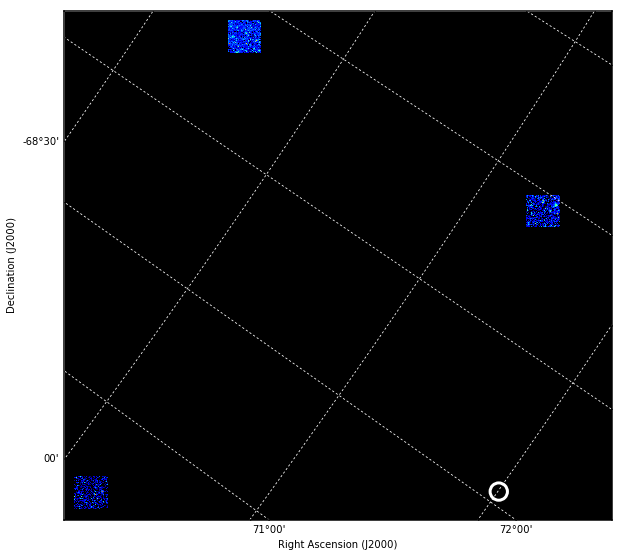

In [8]:
# load the files to list and get number
my_image_files = glob.glob(os.path.join('test_files_3.6um', '*.fits'))
n_images = len(my_image_files)


def plot_image(data, wcs, coords=None):
    """
    convience function to plot data on a wcs projection
    
    Input:
    data -    the data array
    wcs -     the WCS object
    coords -  the coordinates of the object for plotting (1x2 array, optional)
    """
    # set up the plot
    fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': wcs})
    
    # set up limits of the colour scale for plotting
    vmin = 1e-2

    # plot
    axs.imshow(data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=vmin))
    axs.scatter(coords[0], coords[1], transform=axs.get_transform('fk5'), s=300, lw=3,
                edgecolor='white', facecolor='none')
    axs.set_facecolor('black')
    axs.coords.grid(True, color='white', ls='dotted')
    axs.coords[0].set_axislabel('Right Ascension (J2000)')
    axs.coords[1].set_axislabel('Declination (J2000)')

    # display the plot
    plt.tight_layout()
    plt.show()


# cycle through images
for i in my_image_files:
    
    # load the file data, header, and wcs
    with fits.open(i) as hdulist:
        header = hdulist[0].header
        data = hdulist[0].data
        wcs = WCS(header)
        
        plot_image(data, wcs, coords=test_src_coord)
